In [2]:
pip install simpy networkx qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 27.0 MB/s eta 0:00:00


In [3]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt
import builtins
from typing import List, Union
from qutip import *
import numpy as np

# Error Model

In [4]:
zero_ket = basis(2,0)
zero_rho = zero_ket * zero_ket.dag()
one_rho = basis(2,1) * basis(2,1).dag()
I = lambda: qeye(2)
H = (sigmaz() + sigmax()) * np.sqrt(1/2)
CNOT = Qobj([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]], dims=[[2,2],[2,2]])


def initial_rho(num_qubits:int):
    """
    Creates an initial density matrix for a system with the specified number of qubits,
    where each qubit is initialized to the |0⟩ state.

    Parameters:
    num_qubits (int): The number of qubits in the system. Must be a positive integer.

    Returns:
    Qobj: The tensor product of the density matrices of all qubits initialized to the |0⟩ state.
    """
    assert isinstance(num_qubits, int) and num_qubits > 0, "num_qubits must be a positive integer."

    zero_rho = basis(2, 0) * basis(2, 0).dag()  # Density matrix for the |0⟩ state
    return tensor([zero_rho for _ in range(num_qubits)])


def bell_state(state:str):
  """
  Returns the requested Bell state as a density matrix.

  Parameters:
  state (str): The label of the Bell state to return.
                Must be one of 'phi+', 'phi-', 'psi+', or 'psi-'.

  Returns:
  Qobj: The density matrix of the requested Bell state.
  """
  if state == 'phi+':
      phi_plus_ket = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
      return phi_plus_ket * phi_plus_ket.dag()

  elif state == 'phi-':
      phi_minus_ket = (tensor(basis(2, 0), basis(2, 0)) - tensor(basis(2, 1), basis(2, 1))).unit()
      return phi_minus_ket * phi_minus_ket.dag()

  elif state == 'psi+':
      psi_plus_ket = (tensor(basis(2, 0), basis(2, 1)) + tensor(basis(2, 1), basis(2, 0))).unit()
      return psi_plus_ket * psi_plus_ket.dag()

  elif state == 'psi-':
      psi_minus_ket = (tensor(basis(2, 0), basis(2, 1)) - tensor(basis(2, 1), basis(2, 0))).unit()
      return psi_minus_ket * psi_minus_ket.dag()

  else:
      raise ValueError("Invalid Bell state label")


def pad_op(op:Qobj, left_padding:int, right_padding:int):
    """
    Pads the given operator with identity operators on the left and right.

    Parameters:
    op (Qobj): The operator to be padded.
    left_padding (int): The number of identity operators to pad on the left.
    right_padding (int): The number of identity operators to pad on the right.

    Returns:
    Qobj: The padded operator.
    """
    assert isinstance(op, Qobj), "op must be a Qobj."
    assert isinstance(left_padding, int) and left_padding >= 0, "left_padding must be a non-negative integer."
    assert isinstance(right_padding, int) and right_padding >= 0, "right_padding must be a non-negative integer."

    if left_padding > 0:
        left_op = tensor([I()] * left_padding)
        op = tensor(left_op, op)

    if right_padding > 0:
        right_op = tensor([I()] * right_padding)
        op = tensor(op, right_op)

    return op


def imperfect_phi_plus_gen(rho:Qobj, num_qubits_left:int, num_qubits_right: int, F_initial: float):
  """
  Generates an imperfect phi+ Bell state with a specified initial fidelity F_initial.

  Parameters:
  rho (Qobj): The initial density matrix of the quantum system.
  num_qubits_left (int): The number of qubits to the left of the target qubits.
  num_qubits_right (int): The number of qubits to the right of the target qubits.
  F_initial (float): The initial fidelity of the phi+ Bell state.

  Returns:
  Qobj: The density matrix of the system after generating the imperfect phi+ Bell state.
  """
  H_op = pad_op(H, left_padding=num_qubits_left, right_padding=num_qubits_right+1)
  CNOT_op = pad_op(CNOT,left_padding=num_qubits_left, right_padding=num_qubits_right)

  print(f"Rho: {rho}")
  print(f"H_op: {H_op}")

  rho = H_op * rho * H_op.dag()
  rho = CNOT_op * rho * CNOT_op.dag()

  K0 = np.sqrt(F_initial ) * pad_op(op=I(), left_padding=num_qubits_left, right_padding=num_qubits_right+1)
  K1 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmax(), left_padding=num_qubits_left, right_padding=num_qubits_right+1)
  K2 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmay(), left_padding=num_qubits_left, right_padding=num_qubits_right+1)
  K3 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmaz(), left_padding=num_qubits_left, right_padding=num_qubits_right+1)
  krauss_ops = [K0, K1, K2, K3]

  # applying Krauss ops
  rho = sum(op * rho * op.dag() for op in krauss_ops)
  return rho



def state_inserter(rho_initial:Qobj, target_qubits:Union[int, list], state:Qobj):
  """
  Inserts a given quantum state into specific positions of a larger quantum network's density matrix.

  Parameters:
  rho_initial (Qobj): The initial density matrix of the quantum network.
  target_qubits (int or list of int): The indices of the target qubits where the state will be inserted.
                                      If an integer is provided, it represents a single qubit.
                                      If a list is provided, it represents multiple qubits.
  state (Qobj): The quantum state to be inserted into the network.

  Returns:
  Qobj: The updated density matrix of the quantum network with the state inserted at the target qubits.

  Raises:
  TypeError: If target_qubits is neither an int nor a list.
  """
  if isinstance(target_qubits, int):
    num_qubits_left = target_qubits
    num_qubits_right = num_qubits - target_qubits - 1

    qubits_left_list = [i for i in range(num_qubits_left)]
    qubits_right_list = [i + num_qubits_left + 1 for i in range(num_qubits_right)]

  elif isinstance(target_qubits, builtins.list):
    num_qubits_left = target_qubits[0]
    num_qubits_right = num_qubits - target_qubits[-1] - 1

    qubits_left_list = [i for i in range(num_qubits_left)]
    qubits_right_list = [i + num_qubits_left + len(target_qubits) for i in range(num_qubits_right)]

  else:
    raise TypeError('Invalid data type for target_qubit, must be int or list')

  rho = state
  if len(qubits_left_list) != 0:
    rho_qubits_left = rho_initial.ptrace(qubits_left_list)
    rho = tensor(rho_qubits_left, rho)

  if len(qubits_right_list) != 0:
    rho_qubits_right = rho_initial.ptrace(qubits_right_list)
    rho = tensor(rho, rho_qubits_right)

  return rho


def time_for_link(eta_eff:float, T_p:float):
  """
  Gets the time taken to generate entanglement between 2 adjacent nodes
  Does this by generating random samples from a geometric distribution with
  success probability eta_eff and then multiplying by time taken for one trial.

  Parameters:
  eta_eff (float): Success probability for the geometric distribution.
  num_samples (int): Number of random samples to generate.

  Returns:
  np.ndarray: Array of random samples from the geometric distribution.
  """
  no_of_trials = np.random.geometric(eta_eff)
  time_per_trial = T_p + 2 * d / c
  time_per_link = no_of_trials * time_per_trial
  return time_per_link


def dephasing_channel(rho:Qobj, t:float, left_padding:int, right_padding:int):
  """
  Applies the dephasing channel to a given density matrix `rho`.

  Parameters:
  rho (Qobj): The initial density matrix of the quantum system.
  t (float): The time over which the dephasing occurs.
  left_padding (int): The number of identity operators to pad on the left.
  right_padding (int): The number of identity operators to pad on the right.
  T_dp (float): The dephasing time constant.

  Returns:
  Qobj: The density matrix of the quantum system after the dephasing channel has been applied.
  """
  dp_prob = (1 - np.exp(-t / T_dp)) / 2
  Z_op = np.sqrt(dp_prob) * pad_op(op=sigmaz(), left_padding=left_padding, right_padding=right_padding)
  I_op = np.sqrt(1 - dp_prob) * pad_op(op=I(), left_padding=left_padding, right_padding=right_padding)
  rho_t = I_op * rho * I_op.dag() + Z_op * rho * Z_op.dag()
  return rho_t



def dark_counts(rho_initial:Qobj, target:int, P_link:float):
  num_qubits_left = target
  num_qubits_right = (num_qubits - 1) - target

  # channel efficiency
  n_ch = lambda L: np.exp(-L/L_att)

  # total probability that a pair is established
  n = P_link * n_ch(d)

  # the chance for a detector to click (including dark counts)
  n_eff = 1 - (1 - n) * ((1 - p_d) ** 2)

  # given a click occurs, the probability it is from a real event
  alpha = lambda n: (n * (1 - p_d)) / n_eff
  k = 1 - alpha(n)

  # defining Krauss operators
  K0 = np.sqrt(1 - 3 * k / 4) * pad_op(op=I(), left_padding=num_qubits_left, right_padding=num_qubits_right)
  K1 = np.sqrt(k / 4) * pad_op(op=sigmax(), left_padding=num_qubits_left, right_padding=num_qubits_right)
  K2 = np.sqrt(k / 4) * pad_op(op=sigmay(), left_padding=num_qubits_left, right_padding=num_qubits_right)
  K3 = np.sqrt(k / 4) * pad_op(op=sigmaz(), left_padding=num_qubits_left, right_padding=num_qubits_right)
  krauss_ops = [K0, K1, K2, K3]

  # applying Krauss ops
  rho = sum(op * rho_initial * op.dag() for op in krauss_ops)

  return rho

def create_qubit_time_lists(n:int):
  """
  Creates a dictionary with keys for qubit time lists.

  Parameters:
  n (int): The number of qubits.

  Returns:
  dict: A dictionary where each key is a string in the format 'q{i}_time' (where {i} is the qubit index)
        and the value is initialized to 0.

  Example:
  >>> create_qubit_time_lists(3)
  {'q0_time': 0, 'q1_time': 0, 'q2_time': 0}
  """
  lists_dict = {}
  for i in range(n):
      lists_dict[f'q{i}_time'] = 0
  return lists_dict



def entanglement_generation(rho, target_qubits, n, P_link, T_p, eta_eff, F_initial=1):
  """
  Generates entanglement across 2 neighboring repeater stations q1 and q2 by
  creating a phi+ Bell state density matrix with fidelity F_initial and inserting
  it into rho_initial. This function assumes no pre-existing entanglement across
  the selected qubits.

  Parameters:
  rho_initial (Qobj): Initial state of the quantum system.
  target_qubits (list of int): Indices of the target qubits to be entangled.
  F_initial (float): Initial fidelity of the phi+ Bell state.
  num_qubits (int): Total number of qubits in the system.
  n (int): Number of trials or attempts.
  P_link (float): Probability of successful entanglement.
  T_p (float): Time period for the process.
  eta_eff (float): Efficiency factor.

  Returns:
  Qobj: The density matrix of the system after entanglement generation.
  """
  # SET UP
  # getting the number of qubits either side of the pair and making a list of them
  q0, q1 = target_qubits[0], target_qubits[1]
  num_qubits_left = q0
  num_qubits_right = (num_qubits - 1) - q1

  # GENERATING PHI+ BELL PAIR WITH FIDELITY F_INITIAL
  rho = imperfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, F_initial)

  # ADDING MEMORY NOISE
  # dephasing channel for q0 (stays in memory for twice as long)
  rho = dephasing_channel(rho=rho, t = 2 * d/c, left_padding = num_qubits_left, right_padding = num_qubits_right + 1)

  # dephasing channel for q1
  rho = dephasing_channel(rho=rho, t = d/c, left_padding = num_qubits_left + 1, right_padding = num_qubits_right)

  # ADDING DARK COUNTS NOISE
  rho = dark_counts(rho_initial=rho, target=q1, P_link=P_link)

  #TIMING
  global current_time
  time_entang = time_for_link(eta_eff, T_p)
  #print('entang time', current_time)

  current_time += time_entang
  globals()[f'q{q0}_time'] = current_time
  globals()[f'q{q1}_time'] = current_time

  return rho




def entanglement_swapping(rho_initial, q0q1, q2q3, lambda_BSM):
  """
  rho_initial = denisty matrix
  q0q1 = list of length 2
  q2q3 = list of length 2
  lambda_BSM = float [0,1], bell state measurement ideality
  """
  # SET UP
  q0, q1 = q0q1[0], q0q1[1]
  q2, q3 = q2q3[0], q2q3[1]
  num_qubits_left = q0
  num_qubits_right = (num_qubits - 1) - q3
  qubits_left_list = [i for i in range(num_qubits_left)]
  qubits_right_list = [i + num_qubits_left+2 for i in range(num_qubits_right)]
  seperation = (q3 - q0) - 1
  bell_measure_op = tensor(I(), bell_state('phi+'), I())
  qubits = [q0, q1, q2, q3]

  # getting the initial state of the 4 qubits and creating 4 qubit density matrix rho
  rho_q0q1 = rho_initial.ptrace(q0q1)
  rho_q2q3 = rho_initial.ptrace(q2q3)
  rho = tensor(rho_q0q1, rho_q2q3)


  # DEPHASING SINCE LAST OPERATION
  # getting  the current time and the times that each of the qubits were last updated
  global current_time
  q0_time = globals()[f'q{q0}_time']
  q1_time = globals()[f'q{q1}_time']
  q2_time = globals()[f'q{q2}_time']
  q3_time = globals()[f'q{q3}_time']

  # applying dephasing memory error for the time that has passed since their state was updated
  for i, qubit in enumerate(qubits):
    rho = dephasing_channel(rho=rho, t = (current_time - globals()[f'q{qubit}_time']), left_padding = i, right_padding = (3-i))


  # PERFORMING BELL MEASUREMENT
  # project 1, 2 into phi+ bell state and take the ptrace of qubits 0, 3
  # rho is now a 2 qubit density matrix
  rho = (bell_measure_op * rho * bell_measure_op.dag()).ptrace([0,3]).unit()


  # ADDING BSM ERROR
  rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())


  # PLACING QUBITS 0,3 BACK INTO RHO OF WHOLE SYSTEM
  # adding qubits to left of state
  if len(qubits_left_list) != 0:
    rho_qubits_left = rho_initial.ptrace(qubits_left_list)
    rho = tensor(rho_qubits_left, rho)

  # adding the qubits between the newly entangled qubits q0, q3 to the right
  rho_middle = tensor([zero_rho for i in range(seperation)])
  rho = tensor(rho, rho_middle)

  # swapping q3 to the end of the tensor product so that now rho_middle is indeed in the middle
  perm_order = [i for i in range(q3+1)]
  q3_index = perm_order.pop(num_qubits_left+1) # remove the index where q3 is now from list (where q1 normally is)
  perm_order.append(q3_index) # append q3 index to end of list, moving q3 to the end
  rho = rho.permute(perm_order)

  # adding qubits to the right of state
  if len(qubits_right_list) != 0:
    rho_qubits_right = rho_initial.ptrace(qubits_right_list)
    rho = tensor(rho, rho_qubits_right)


  # UPDATING TIMING
  # assuming instantaneous BSM
  globals()[f'q{q0}_time'] = current_time
  globals()[f'q{q1}_time'] = current_time
  globals()[f'q{q2}_time'] = current_time
  globals()[f'q{q3}_time'] = current_time
  #print(current_time)
  return rho

# GLOBAL PARAMETERS
# Geometric Set Up
num_qubits = 8
total_L = 100e3
d = total_L/(num_qubits - 1)

# Optical Fiber Properties
L_att = 22e3       # attenuation length of optical fiber
c = 2e8            # speed of light in fiber optic

# Global Error Parameters
T_dp = 100         # dephasing time constant (memory error)
p_d = 0            # probability a dark count will occur in a detection window

# DEFINING ENTANGLEMENT GENERATION PARAMETERS
entang_gen_args = {
    'n' : 1,             # probability a link is established between 2 neighbouring repeater stations
    'P_link' : 1,        # probability a link is established without considering distance based losses
    'T_p' : 0,           # time to prepare an entangled pair
    'eta_eff' : 1        # effective channel efficiency
}

In [58]:
def initial_rho(num_qubits: int):
    assert isinstance(num_qubits, int) and num_qubits > 0, "num_qubits must be a positive integer."
    zero_rho = basis(2, 0) * basis(2, 0).dag()  # Density matrix for the |0⟩ state
    return tensor([zero_rho for _ in range(num_qubits)])

def pad_op(op: Qobj, left_padding: int, right_padding: int, num_qubits: int):
    assert isinstance(op, Qobj), "op must be a Qobj."
    assert isinstance(left_padding, int) and left_padding >= 0, "left_padding must be a non-negative integer."
    assert isinstance(right_padding, int) and right_padding >= 0, "right_padding must be a non-negative integer."

    if left_padding > 0:
        left_op = tensor([I()] * left_padding)
        op = tensor(left_op, op)

    if right_padding > 0:
        right_op = tensor([I()] * right_padding)
        op = tensor(op, right_op)

    return op

def imperfect_phi_plus_gen(rho: Qobj, num_qubits_left: int, num_qubits_right: int, F_initial: float, num_qubits: int):
    H_op = pad_op(H, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    CNOT_op = pad_op(CNOT, left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)

    rho = H_op * rho * H_op.dag()
    rho = CNOT_op * rho * CNOT_op.dag()

    K0 = np.sqrt(F_initial) * pad_op(op=I(), left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    K1 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmax(), left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    K2 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmay(), left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    K3 = np.sqrt((1 - F_initial) / 3) * pad_op(op=sigmaz(), left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    krauss_ops = [K0, K1, K2, K3]

    rho = sum(op * rho * op.dag() for op in krauss_ops)
    return rho


def dephasing_channel(rho: Qobj, t: float, left_padding: int, right_padding: int, num_qubits: int):
    dp_prob = (1 - np.exp(-t / T_dp)) / 2
    Z_op = np.sqrt(dp_prob) * pad_op(op=sigmaz(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    I_op = np.sqrt(1 - dp_prob) * pad_op(op=I(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    rho_t = I_op * rho * I_op.dag() + Z_op * rho * Z_op.dag()
    return rho_t

def dark_counts(rho_initial: Qobj, target: int, P_link: float, num_qubits: int):
    num_qubits_left = target
    num_qubits_right = (num_qubits - 1) - target

    n_ch = lambda L: np.exp(-L / L_att)
    n = P_link * n_ch(d)
    n_eff = 1 - (1 - n) * ((1 - p_d) ** 2)
    alpha = lambda n: (n * (1 - p_d)) / n_eff
    k = 1 - alpha(n)

    K0 = np.sqrt(1 - 3 * k / 4) * pad_op(op=I(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K1 = np.sqrt(k / 4) * pad_op(op=sigmax(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K2 = np.sqrt(k / 4) * pad_op(op=sigmay(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K3 = np.sqrt(k / 4) * pad_op(op=sigmaz(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    krauss_ops = [K0, K1, K2, K3]

    rho = sum(op * rho_initial * op.dag() for op in krauss_ops)
    return rho

def entanglement_generation(communication, rho: Qobj, target_qubits: list, n: int, P_link: float, T_p: float, eta_eff: float, num_qubits: int, F_initial=1):
    """
    NOTE: q1 must be greater than q0
    """
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    rho = imperfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, F_initial, num_qubits)

    # dephasing on q0
    rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    communication.qubit_times[q0] += 1
    # dephasing on q1
    rho = dephasing_channel(rho=rho, t=d / c, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)
    communication.qubit_times[q1] += 0.5

    if q0 > 1:
        # dephasing on left of q0
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left - 1, right_padding=num_qubits_right + 2, num_qubits=num_qubits)
        communication.qubit_times[q0-1] += 1
        # dephasing on first qubit
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=0, right_padding=num_qubits - 1, num_qubits=num_qubits)
        communication.qubit_times[0] += 1

    for i in range (num_qubits):
        print(f"Qubit {i}: {rho.ptrace(i).full()}\n")

    #rho = dark_counts(rho_initial=rho, target=q1, P_link=P_link, num_qubits=num_qubits)


    print(communication.qubit_times)
    return rho

def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int, lambda_BSM=1):
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    bell_measure_op = pad_op(bell_state('phi+'), left_padding = num_qubits_left, right_padding = num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()

    # adding bell state measurement error
    #rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())
    return rho


Length of path reserved: 5
CURRENT NODE: 0
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 3: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 4: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 5: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[1, 0.5, 0, 0, 0, 0, 0, 0]
TIME: 1


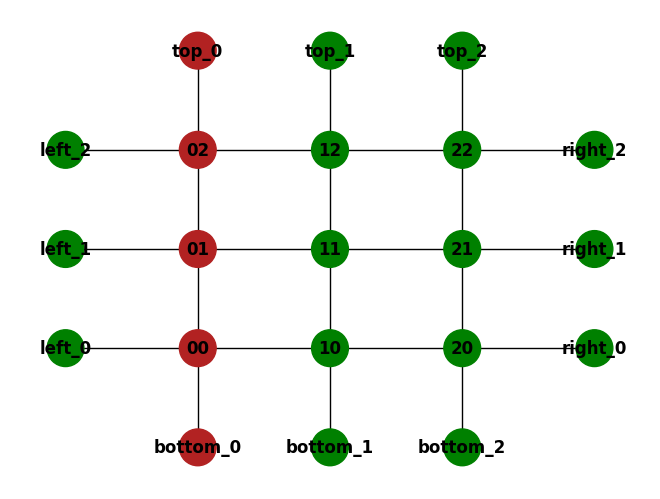

CURRENT NODE: 1
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 3: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 4: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 5: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[2, 1.5, 1, 0.5, 0, 0, 0, 0]
TIME: 2


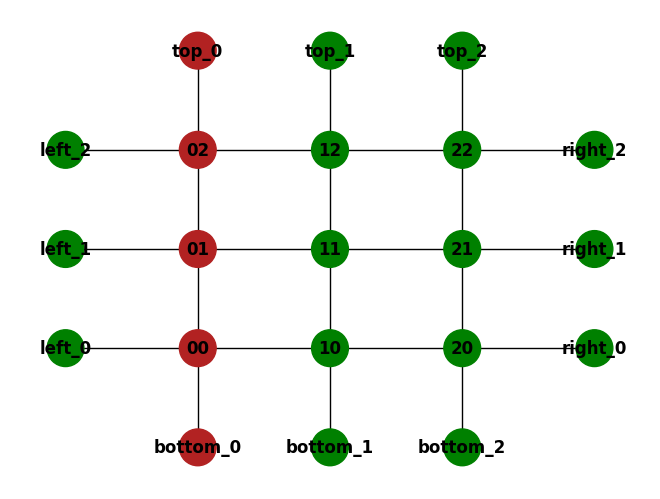

CURRENT NODE: 2
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 3: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 4: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 5: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[3, 1.5, 1, 1.5, 1, 0.5, 0, 0]
Time 3: Node 02 is freed.
TIME: 3


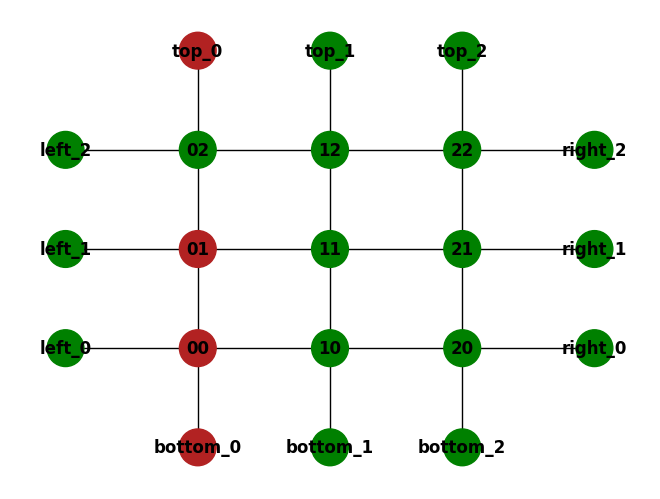

CURRENT NODE: 3
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 3: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 4: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 5: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 6: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 7: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

[4, 1.5, 1, 1.5, 1, 1.5, 1, 0.5]
Time 4: Node 01 is freed.
TIME: 4


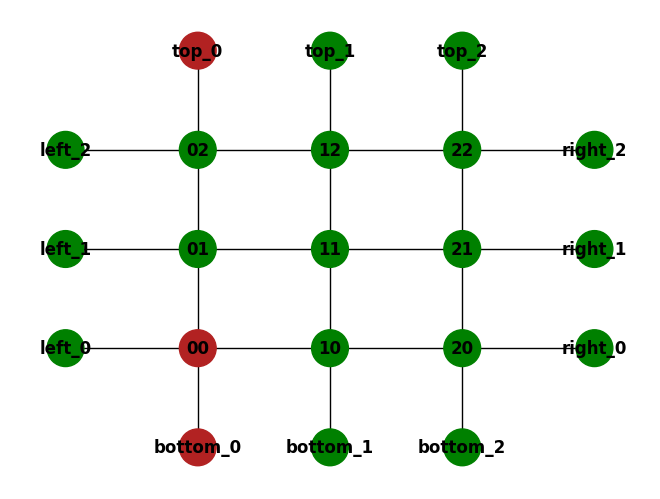

Length of path reserved: 6
CURRENT NODE: 0
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 3: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 4: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 5: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 8: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 9: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Time 5: Node 00 is freed.
TIME: 5


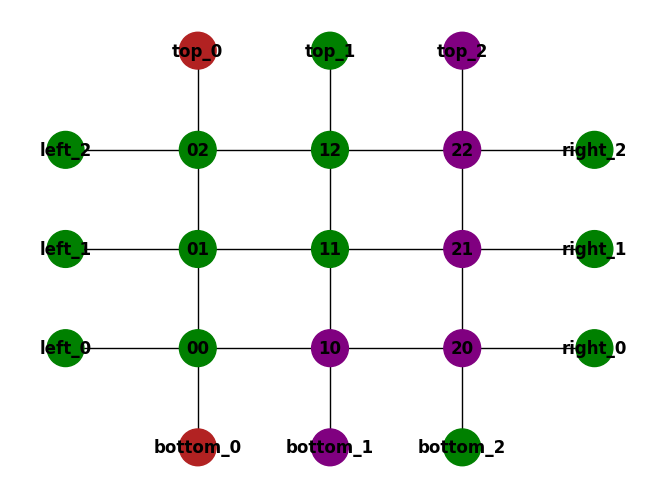

CURRENT NODE: 1
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 3: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 4: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 5: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 8: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 9: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[2, 1.5, 1, 0.5, 0, 0, 0, 0, 0, 0]
Time 6: Node bottom_0 is freed.
Time 6: Node top_0 is freed.
TIME: 6


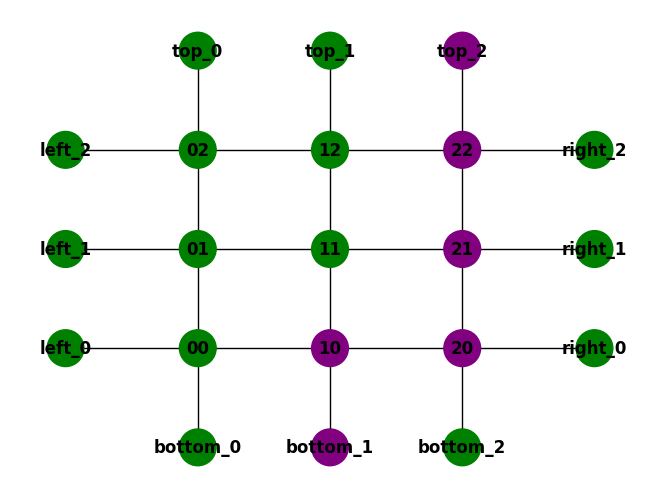

CURRENT NODE: 2
Qubit 0: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 1: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 2: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 3: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 4: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 5: [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

Qubit 6: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 7: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 8: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Qubit 9: [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

[3, 1.5, 1, 1.5, 1, 0.5, 0, 0, 0, 0]
TIME: 7


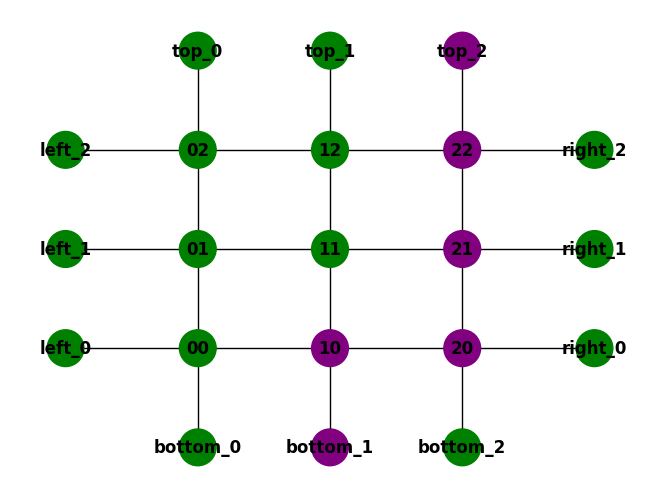

TypeError: incompatible dimensions [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]] and [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]

In [46]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt

class CustomGrid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env
        self.network = self.create_custom_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_custom_grid_network(self):
        """
        Create a grid-based network graph with additional nodes connected to the edge nodes.
        """
        network = nx.Graph()

        # Create the standard grid network
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)

        # Add edges for the standard grid connections
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)

        # Add external nodes for each edge node and connect them
        for y in range(self.grid_size):
            network.add_node(f"left_{y}")
            network.add_edge(f"0{y}", f"left_{y}")
            network.add_node(f"right_{y}")
            network.add_edge(f"{self.grid_size - 1}{y}", f"right_{y}")

        for x in range(self.grid_size):
            network.add_node(f"bottom_{x}")
            network.add_edge(f"{x}0", f"bottom_{x}")
            network.add_node(f"top_{x}")
            network.add_edge(f"{x}{self.grid_size - 1}", f"top_{x}")

        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with node colors based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}

        for y in range(self.grid_size):
            pos[f"left_{y}"] = (-1, y)
            pos[f"right_{y}"] = (self.grid_size, y)
        for x in range(self.grid_size):
            pos[f"bottom_{x}"] = (x, -1)
            pos[f"top_{x}"] = (x, self.grid_size)

        colors = ['green' if self.node_statuses[node] == 'free' else shades_of_red[self.node_statuses[node]] for node in self.network.nodes()]

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free'.
        """
        self.node_statuses[node] = 'free'
        print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, color_index):
        """
        Reserve the path by marking all nodes as 'busy' with the communication color index.
        """
        for node in path:
            self.node_statuses[node] = color_index

class Communication:
    def __init__(self, communication_id, path, grid, color_index):
        self.communication_id = communication_id
        self.path = path
        self.current_node_index = 0
        self.grid = grid
        self.color_index = color_index
        self.grid.reserve_path(self.path, self.color_index)
        self.num_nodes = len(path)
        self.num_qubits = 2 * self.num_nodes - 2
        self.rho = initial_rho(self.num_qubits)
        self.qubit_times = [0] * self.num_qubits  # Initialize qubit times

    def advance(self):
        """
        Move the communication to the next node in the path and free the previous node, except for the first node.
        """

        if not self.is_complete():
            first_qubit = 2 * self.current_node_index
            print("CURRENT NODE:", self.current_node_index)
            self.rho = entanglement_generation(self, rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits, **entang_gen_args)
            self.current_node_index += 1

            if self.current_node_index > 2:  # Start freeing nodes only after the second node
                previous_node = self.path[self.current_node_index - 2] # current node index -1
                self.rho = entanglement_swapping(rho=self.rho, target_qubits=[first_qubit - 1, first_qubit], num_qubits = num_qubits)
                self.grid.free_node(previous_node)



    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return self.current_node_index == len(self.path) - 1

    def complete_communication(self, env):
        """
        Free the first node, last node, and the second-to-last node after the communication is complete.
        """
        if len(self.path) > 1:
            self.grid.free_node(self.path[-2])  # Free second-to-last node
            yield env.timeout(1)
        self.grid.free_node(self.path[-1])  # Free last node
        self.grid.free_node(self.path[0])  # Free first node
        yield env.timeout(0)  # Ensure this method behaves like a generator

def communication_manager(env, grid, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    print(f"Length of path reserved: {len(path)}")
                    color_index = current_id % len(shades_of_red)  # Cycle through shades of red
                    communication = Communication(current_id, path, grid, color_index)
                    env.process(move_packet(env, communication))
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)

        yield env.timeout(1)

def move_packet(env, communication):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    """
    while not communication.is_complete():
        communication.advance()
        yield env.timeout(1)
    yield env.process(communication.complete_communication(env))

def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    """
    while True:
        yield env.timeout(1)
        print(f"TIME: {env.now}")
        grid.plot_network(shades_of_red)

def generate_communications(env, grid, communication_queue):
    """
    Generate communication attempts between edge nodes according to the rules.
    """
    top_nodes = [f"top_{x}" for x in range(grid.grid_size)]
    bottom_nodes = [f"bottom_{x}" for x in range(grid.grid_size)]
    left_nodes = [f"left_{y}" for y in range(grid.grid_size)]
    right_nodes = [f"right_{y}" for y in range(grid.grid_size)]

    communication_id = 0

    while True:
        source_group = random.choice(['top', 'bottom', 'left', 'right'])

        if source_group == 'top':
            source_node = random.choice(top_nodes)
            target_node = random.choice(bottom_nodes)
        elif source_group == 'bottom':
            source_node = random.choice(bottom_nodes)
            target_node = random.choice(top_nodes)
        elif source_group == 'left':
            source_node = random.choice(left_nodes)
            target_node = random.choice(right_nodes)
        elif source_group == 'right':
            source_node = random.choice(right_nodes)
            target_node = random.choice(left_nodes)

        # Generate the shortest path between source and target
        all_paths = list(nx.all_shortest_paths(grid.network, source=source_node, target=target_node))

        path_reserved = False

        for path in all_paths:
            if grid.is_path_free(path):
                communication_queue.append((env.now, source_node, target_node, communication_id))
                path_reserved = True
                break

        if path_reserved:
            communication_id += 1

        yield env.timeout(1)  # Wait for the next time step

# Main execution
grid_size = 3
random.seed(2)

# Create the simulation environment
env = simpy.Environment()

# Create and connect the grid network
grid = CustomGrid(grid_size, env)

# Generate different shades of red for communications
shades_of_red = ["#B22222", "#800080", "#B03060", "#DAA520", "#BC8F8F"]

# List to store communication attempts
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, grid, communication_queue, shades_of_red))

# Generate communication attempts from edge nodes
env.process(generate_communications(env, grid, communication_queue))

# Start the plot manager
env.process(plot_manager(env, grid, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps


# Testing out partial tracing

In [63]:

def entanglement_generation(rho: Qobj, target_qubits: list, num_qubits: int, n: int, P_link: float, T_p: float, eta_eff: float, F_initial=0.7):
    """
    NOTE: q1 must be greater than q0
    """
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    rho = imperfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, F_initial, num_qubits)

    # dephasing on q0
    rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)

    # dephasing on q1
    rho = dephasing_channel(rho=rho, t=d / c, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)


    if q0 > 1:
        # dephasing on left of q0
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left - 1, right_padding=num_qubits_right + 2, num_qubits=num_qubits)

        # dephasing on first qubit
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=0, right_padding=num_qubits - 1, num_qubits=num_qubits)


    #rho = dark_counts(rho_initial=rho, target=q1, P_link=P_link, num_qubits=num_qubits)

    return rho

def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int, lambda_BSM=1):
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    bell_measure_op = pad_op(bell_state('phi+'), left_padding = num_qubits_left, right_padding = num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()

    # adding bell state measurement error
    #rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())
    return rho



num_qubits = 8
rho = initial_rho(num_qubits)
rho = entanglement_generation(rho=rho, target_qubits=[0,1], num_qubits=num_qubits,  **entang_gen_args)
rho = entanglement_generation(rho = rho, target_qubits=[2,3], num_qubits=num_qubits,  **entang_gen_args)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL TRACE B4')
print("Q0Q1\n", rho.ptrace([0,1]).full())
print("Q2Q3\n", rho.ptrace([2,3]).full())
rho = entanglement_swapping(rho = rho , target_qubits = [1,2], num_qubits=num_qubits)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL AFTER')
print("Q0Q3\n", rho.ptrace([0,3]).full())



PARTIAL TRACE B4
Q0Q1
 [[0.4      +0.j 0.       +0.j 0.       +0.j 0.2999985+0.j]
 [0.       +0.j 0.1      +0.j 0.       +0.j 0.       +0.j]
 [0.       +0.j 0.       +0.j 0.1      +0.j 0.       +0.j]
 [0.2999985+0.j 0.       +0.j 0.       +0.j 0.4      +0.j]]
Q2Q3
 [[0.4       +0.j 0.        +0.j 0.        +0.j 0.29999936+0.j]
 [0.        +0.j 0.1       +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.1       +0.j 0.        +0.j]
 [0.29999936+0.j 0.        +0.j 0.        +0.j 0.4       +0.j]]
PARTIAL AFTER
Q0Q3
 [[0.34      +0.j 0.        +0.j 0.        +0.j 0.17999871+0.j]
 [0.        +0.j 0.16      +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.16      +0.j 0.        +0.j]
 [0.17999871+0.j 0.        +0.j 0.        +0.j 0.34      +0.j]]
